### Import Libraries

In [115]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size']=15
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tqdm.notebook import tqdm
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,MaxPooling1D,Bidirectional,Dense,Dropout,Flatten,LSTM
from tensorflow.keras.optimizers import RMSprop,Adam

In [116]:
#Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Loading

In [117]:
df=pd.read_csv("/content/drive/MyDrive/GenuineReviewerIdentification/7817_1.csv")
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,manufacturer,manufacturerNumber,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-08-08T00:00:00.000Z,NaN,139.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-09-01T00:00:00.000Z,NaN,126.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-07-20T00:00:00.000Z,NaN,69.0,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2017-06-16T00:00:00.000Z,NaN,2.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2016-08-11T00:00:00.000Z,NaN,17.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


### Data Preprocessing

In [118]:
#Print the total number of rows and columns in the dataset/dataframe
df.shape

(1597, 27)

Text(0, 0.5, 'Count')

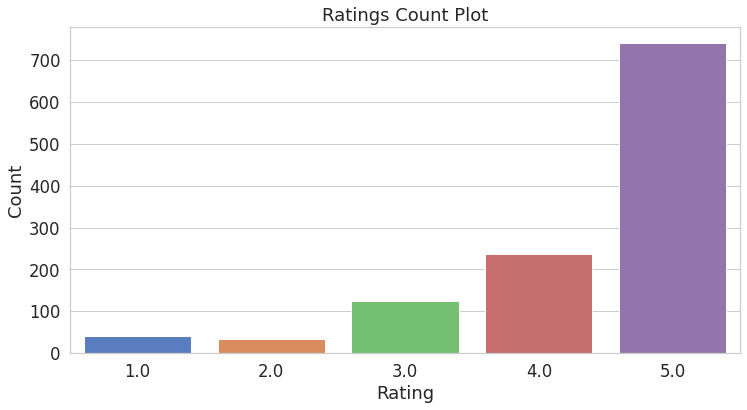

In [119]:
#Data Visualisation
#Ratings Count Plot - The x-axis reveals the five classes of Ratings whilst the y-axis shows the count for each Rating class

f, ax= plt.subplots(figsize=(12,6))
desv = sns.countplot(df['reviews.rating'], ax=ax)
desv.set_title('Ratings Count Plot')
desv.set_xlabel('Rating')
desv.set_ylabel('Count')

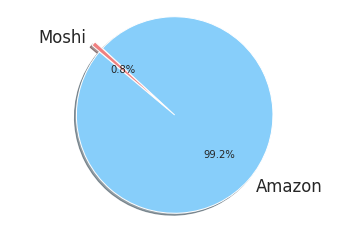

In [120]:
#Data Visualisation
#Brand Pie Chart

#Each Ratings
labels = df['brand'].unique()

#Total number of each Brand 
count1 = (df['brand'] == "Amazon").sum()
count2 = (df['brand'] == "Moshi").sum()

sizes = [count1, count2]
colors = ['lightskyblue', 'lightcoral']
explode = (0.0, 0.1)  #explode 2nd slice

#Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

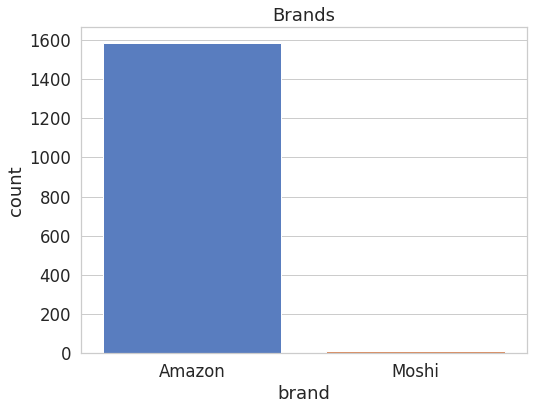

In [121]:
#Transform data
df.brand[df['brand'] == 'Amazon'] = "Amazon"
df.brand[df['brand'] == 'Moshi'] = "Moshi"

#Visualize Brands count
plt.figure(figsize = (8,6))
sns.countplot(df['brand'])
plt.title("Brands")
plt.show()

In [122]:
#Storing only the required columns to the dataframe "df"
df=df[["reviews.text","reviews.rating"]]
#Printing the final datafarame
df.head()

,reviews.text,reviews.rating
0,I initially had trouble deciding between the p...,5.0
1,Allow me to preface this with a little history...,5.0
2,I am enjoying it so far. Great for reading. Ha...,4.0
3,I bought one of the first Paperwhites and have...,5.0
4,I have to say upfront - I don't like coroporat...,5.0


In [123]:
#Checking for null values inside the dataframe
df.isnull().sum()

reviews.text        0
reviews.rating    420
dtype: int64

In [124]:
#Removig the null values
df=df.dropna().reset_index(drop=True)

In [125]:
#Dataframe Shape after the removal of null values
df.shape

(1177, 2)

In [126]:
#Checking Null Values again
df.isnull().sum()

reviews.text      0
reviews.rating    0
dtype: int64

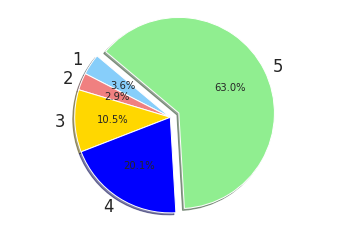

In [127]:
#Ratings Pie Chart

#Each Ratings
labels = df['reviews.rating'].unique()

#Total number of each ratings 
count1 = (df['reviews.rating'] == 1.0).sum()
count2 = (df['reviews.rating'] == 2.0).sum()
count3 = (df['reviews.rating'] == 3.0).sum()
count4 = (df['reviews.rating'] == 4.0).sum()
count5 = (df['reviews.rating'] == 5.0).sum()

sizes = [count1, count2, count3, count4, count5]
colors = ['lightskyblue', 'lightcoral', 'gold', 'blue', 'lightgreen']
explode = (0.0,0.0, 0.0, 0.0, 0.1)  #explode 5th slice

#Plot
plt.pie(sizes, explode=explode, labels=[1,2,3,4,5], colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [128]:
#Renaming the columns' names to "text" & "label"
df.columns=["text","label"]
df.head()

,text,label
0,I initially had trouble deciding between the p...,5.0
1,Allow me to preface this with a little history...,5.0
2,I am enjoying it so far. Great for reading. Ha...,4.0
3,I bought one of the first Paperwhites and have...,5.0
4,I have to say upfront - I don't like coroporat...,5.0


In [129]:
#Text Sentiment
df['label']=df['label'].apply(lambda x: "positive" if x>=3.0 else "negative")

#A random 100% sample of the DataFrame
#Shuffle DataFrame rows
df=df.sample(frac=1).reset_index(drop=True)

df.head()

,text,label
0,I have an Amazon Echo and an Amazon Dot. Love ...,positive
1,Very easy to setup and use. Still learning to ...,positive
2,I have the Echo and bought this one for the be...,positive
3,"Having received my Fire TV today, I've been tr...",positive
4,I bought 2 of these for christmas presents and...,positive


In [130]:
#Checking the total count of positive and negative reviews in the Dataframe
df['label'].value_counts()

positive    1101
negative      76
Name: label, dtype: int64

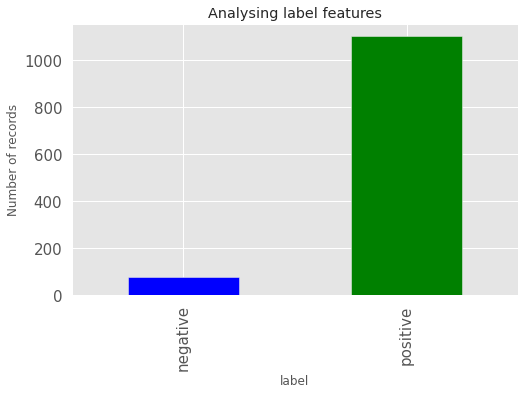

In [131]:
#Graphical Representation
with plt.style.context(style='ggplot'):
    df['label'].value_counts(ascending=True).plot.bar(figsize=(8,5),fontsize=15,color=['blue','green'])
    plt.title(label='Analysing label features')
    plt.xlabel(xlabel='label')
    plt.ylabel(ylabel='Number of records')
    plt.show()

## **Upsampling**
The number of class variables should be increased for better training and testing datasets. Hence, the random upsampling technique solves the risk of biased classification of dataset.

In [132]:
#Upsampling
from sklearn.utils import resample
oversampled=[]
for label in df['label'].unique():
    oversampled.append(resample(df.loc[df['label']==label],n_samples=1500))
df=pd.concat(objs=oversampled,ignore_index=True)
df=df.sample(frac=1).reset_index(drop=True)

In [133]:
df.head()

,text,label
0,I typically don't post reviews however don't w...,negative
1,Worked great for a few weeks then completely s...,negative
2,For the love of god do not buy this!!! Thought...,negative
3,"While this case fits a 7th Gen Fire perfectly,...",negative
4,"Love the Tap, plays my daughter' s music. Work...",positive


In [134]:
df.shape

(3000, 2)

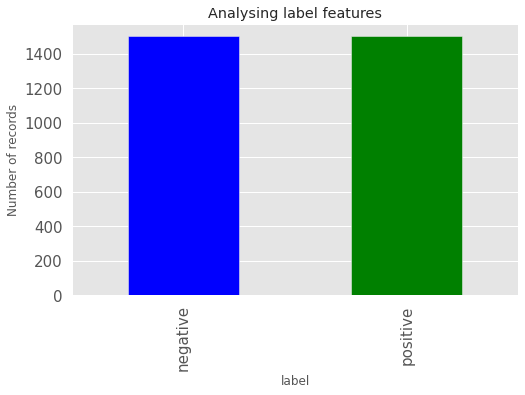

In [135]:
#upsampled dataframe
with plt.style.context(style='ggplot'):
    df['label'].value_counts(ascending=True).plot.bar(figsize=(8,5),fontsize=15,color=['blue','green'])
    plt.title(label='Analysing label features')
    plt.xlabel(xlabel='label')
    plt.ylabel(ylabel='Number of records')
    plt.show()

***Text Cleaning***

**spaCy** is a free, open-source library for advanced Natural Language Processing (NLP) in Python. spaCy is designed specifically for production use and helps you build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.

In [136]:
import string
punctuations=string.punctuation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords=set(STOP_WORDS)
#Load language model English
nlp=spacy.load("en_core_web_sm")

**Spacy Lemmatization** which gives the lemma of the word, lemma is nothing the but base word which has been converted through the process of lemmatization for e.g 'hostorical', 'history' will become 'history' so the lemma is 'history'.

In [137]:
#Spacy aggressive lemmatization and removing unexpected words
#Lemmatization is one of the common text pre-processing tasks in NLP that reduces a given word to its root word. 
#For example cars, car’s will be lemmatized into car. In the same way, are, is, am is lemmatized to be.
def text_cleaning(docx):
    sentence=[word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in docx]
    sentence=[word for word in sentence if word not in stopwords and word not in punctuations]
    sentence=[word for word in sentence if len(word)>1 and word.isalpha()]
    sentence=" ".join(sentence)
    return sentence

# **cword-dict.pkl File**

A  pickle file named as cword-dict.pkl is used here. It is basically a dictionary with contractions as key and their expansions as the value. It has been created by the researcher herself after referring
few resources. It is used for expanding the contractions.

In [138]:
import pickle
with open('/content/drive/MyDrive/GenuineReviewerIdentification/cword_dict.pkl', 'rb') as f:
    data = pickle.load(f)

data

{"ain't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he's": 'he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must 

In [139]:
#Expand the contractions
import re
import pickle

with open("/content/drive/MyDrive/GenuineReviewerIdentification/cword_dict.pkl",mode='rb') as file:
    cList=pickle.load(file=file)
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group()]
    return c_re.sub(replace, text)

In [140]:
#from cleantext import clean
#tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm.notebook import tqdm
cleaned_sentence=[]
for sentence in tqdm(df['text'].values):
    sent=expandContractions(sentence)
    sent=nlp(sent.lower())
    cleaned_sentence.append(text_cleaning(sent))
df['text']=cleaned_sentence
df['text']=df['text'].apply(str)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [141]:
#Priting cleaned dataframe
df.head()

,text,label
0,typically post review waste money case friday ...,negative
1,work great week completely stop work box return,negative
2,love god buy think great add size phone stick ...,negative
3,case fit gen fire perfectly comfortable way ho...,negative
4,love tap play daughter music work amazon prime...,positive


# **Word Cloud** 
is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.

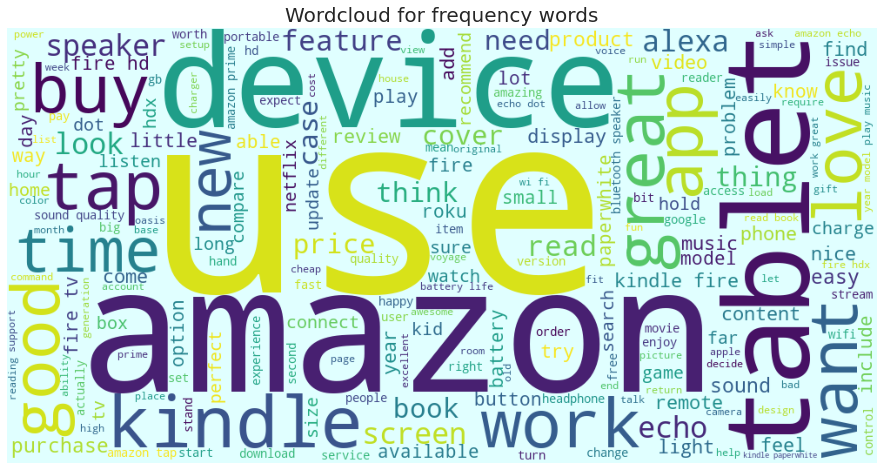

In [142]:
from wordcloud import WordCloud, STOPWORDS
stopwords=set(STOPWORDS)
#The FreqDist function gives the user the frequency distribution of all the words in the text
from nltk import FreqDist
doc_list = list(df['text'])
words = [sublist for sublist in doc_list]
word= FreqDist(words)
plt.figure(figsize=(18,8))
wordcloud = WordCloud(width = 1000,background_color ='lightcyan', height = 500,stopwords=stopwords).generate(",".join(str(v) for v in word))  
plt.imshow(wordcloud)
plt.axis("off")
plt.title(label='Wordcloud for frequency words',fontsize=20)
plt.show()

In [143]:
df.head()

,text,label
0,typically post review waste money case friday ...,negative
1,work great week completely stop work box return,negative
2,love god buy think great add size phone stick ...,negative
3,case fit gen fire perfectly comfortable way ho...,negative
4,love tap play daughter music work amazon prime...,positive


# **Label Encoding**

Positive: 0

Negative: 1

In [144]:
df['label']=df['label'].map({'positive':0,'negative':1})
#Shuffle DataFrame rows
df=df.sample(frac=1).reset_index(drop=True)
df.head(5)

,text,label
0,complete waste read review think product thin ...,1
1,fun buy informative understand question,1
2,review update september background retired inf...,0
3,low price tablet expect camera great use phone...,0
4,purchase tv fire box year ago purchase second ...,1


***Vectorization***

In [145]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [146]:
#Sentences are broken into unique tokens
#converting a sequence of characters into a sequence of lexical tokens
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df['text'].values)
sequence_data=tokenizer.texts_to_sequences(df['text'].values)

print(sequence_data[:5],"\n")
vocab_size=len(tokenizer.word_index)+1
print("Unique Tokens size : {}".format(len(tokenizer.word_index)+1))

[[430, 279, 35, 26, 21, 24, 321, 216, 995, 294, 115, 458, 867, 97, 588, 431, 662, 1, 358, 303, 67], [403, 10, 1245, 193, 137], [26, 70, 1578, 404, 1529, 868, 363, 1530, 196, 26, 1399, 77, 16, 5, 97, 849, 170, 2, 7, 3, 172, 361, 5, 12, 98, 2, 2, 2, 2, 26, 12, 5, 98, 1869, 242, 5, 1198, 12, 5, 182, 828, 787, 770, 66, 1693, 902, 284, 74, 173, 300, 27, 66, 98, 300, 104, 93, 66, 69, 93, 66, 326, 110, 596, 1287, 66, 43, 174, 296, 758, 110, 9, 11, 46, 1870, 69, 93, 66, 116, 618, 296, 174, 93, 66, 618, 110, 417, 549, 11, 103, 43, 99, 98, 7, 280, 101, 941, 219, 349, 218, 3, 589, 194, 1314, 157, 146, 98, 383, 549, 232, 1199, 1531, 1199, 565, 150, 17, 405, 28, 159, 98, 159, 417, 1479, 671, 788], [164, 39, 15, 119, 192, 9, 1, 42, 192, 720, 499, 374, 499, 164, 168, 117, 270, 9, 13, 53, 335, 30, 9, 759, 974, 48, 177, 3, 37, 57, 48, 1140, 488, 57, 20, 11, 103, 340, 566, 4, 1141, 23, 647, 97, 1, 192, 53, 9, 996, 271, 41, 117, 39, 15, 1142, 997, 174, 74, 350, 350, 126, 220, 272, 543, 13, 384, 74, 444, 

In [147]:
print(tokenizer.word_index.items())

dict_items([('use', 1), ('fire', 2), ('amazon', 3), ('work', 4), ('kindle', 5), ('like', 6), ('device', 7), ('remote', 8), ('great', 9), ('buy', 10), ('battery', 11), ('new', 12), ('screen', 13), ('echo', 14), ('tablet', 15), ('time', 16), ('good', 17), ('sound', 18), ('cover', 19), ('tv', 20), ('think', 21), ('problem', 22), ('app', 23), ('product', 24), ('love', 25), ('review', 26), ('year', 27), ('case', 28), ('want', 29), ('look', 30), ('tap', 31), ('thing', 32), ('feel', 33), ('purchase', 34), ('read', 35), ('speaker', 36), ('prime', 37), ('headphone', 38), ('price', 39), ('voice', 40), ('feature', 41), ('phone', 42), ('come', 43), ('try', 44), ('nice', 45), ('book', 46), ('controller', 47), ('easy', 48), ('hd', 49), ('music', 50), ('button', 51), ('video', 52), ('quality', 53), ('apple', 54), ('alexa', 55), ('month', 56), ('content', 57), ('way', 58), ('dot', 59), ('play', 60), ('people', 61), ('find', 62), ('free', 63), ('hdx', 64), ('stick', 65), ('model', 66), ('day', 67), ('c

In [148]:
#Written into a pickle file Tokenizer.pkl
import pickle
with open(file='/content/drive/MyDrive/GenuineReviewerIdentification/Tokenizer.pkl',mode='wb') as file:
    pickle.dump(obj=tokenizer,file=file)

In [149]:
#Pad_sequences is used to ensure that all sequences in a list have the same length.
#pad the text with same dimensionality 
pad_text=pad_sequences(sequences=sequence_data,maxlen=200,padding='post',truncating='post')
print(pad_text[:5])

[[ 430  279   35   26   21   24  321  216  995  294  115  458  867   97
   588  431  662    1  358  303   67    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [150]:
y=df['label'].values
y

array([1, 1, 0, ..., 0, 1, 1])

The column ”label,” which was originally a numpy array
of integers to represent the various categories in the data, was converted using the tocategorical() function into a numpy array or matrix with binary values and as many columns as there were categories in the data.

In [151]:
y=to_categorical(y=y,num_classes=2)
print(y)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


### Data Splitting

In [152]:
X_train,X_test,y_train,y_test=train_test_split(pad_text,y,test_size=0.3,random_state=37)
#random_state=42
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2100, 200) (900, 200) (2100, 2) (900, 2)


***Glove word Embedding***

Global Vectors for Word Representation, or GloVe, is an “unsupervised learning algorithm for obtaining vector representations for words.”

In [153]:
embeddings_index = {}
with open('/content/drive/MyDrive/GenuineReviewerIdentification/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
embedding_dimention = 50
def embedding_matrix_creater(embedding_dimention, word_index):
    embedding_matrix = np.zeros((len(word_index)+1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = embedding_matrix_creater(50, word_index=tokenizer.word_index)    
print("Glove Loded!")

Glove Loded!


### Model Building

In [154]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,MaxPooling1D,Bidirectional,Dense,Dropout,Flatten,LSTM
from tensorflow.keras.optimizers import RMSprop,Adam

In [155]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=pad_text.shape[1],weights=[embedding_matrix]))
model.add(Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu'))
model.add(Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(200,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(200)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

In [156]:
#Summary of the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           170700    
                                                                 
 conv1d_2 (Conv1D)           (None, 198, 64)           9664      
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 98, 400)          424000    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)             

In [157]:
#fit() method will fit the model to the input training instances 
history=model.fit(x=X_train,y=y_train,batch_size=32,epochs=8,validation_data=(X_test,y_test))

Epoch 1/8
66/66 [==============================] - 11s 53ms/step - loss: 0.6778 - accuracy: 0.5871 - val_loss: 0.6210 - val_accuracy: 0.6633
Epoch 2/8
66/66 [==============================] - 2s 30ms/step - loss: 0.5192 - accuracy: 0.7381 - val_loss: 0.4123 - val_accuracy: 0.7911
Epoch 3/8
66/66 [==============================] - 2s 31ms/step - loss: 0.3761 - accuracy: 0.8267 - val_loss: 0.3354 - val_accuracy: 0.8589
Epoch 4/8
66/66 [==============================] - 2s 31ms/step - loss: 0.2661 - accuracy: 0.8890 - val_loss: 0.2089 - val_accuracy: 0.9156
Epoch 5/8
66/66 [==============================] - 2s 31ms/step - loss: 0.2002 - accuracy: 0.9229 - val_loss: 0.1644 - val_accuracy: 0.9378
Epoch 6/8
66/66 [==============================] - 2s 31ms/step - loss: 0.1419 - accuracy: 0.9424 - val_loss: 0.2630 - val_accuracy: 0.9089
Epoch 7/8
66/66 [==============================] - 2s 30ms/step - loss: 0.1095 - accuracy: 0.9576 - val_loss: 0.0989 - val_accuracy: 0.9756
Epoch 8/8
66/66 [==

***Accuracy and Loss plot graphs***

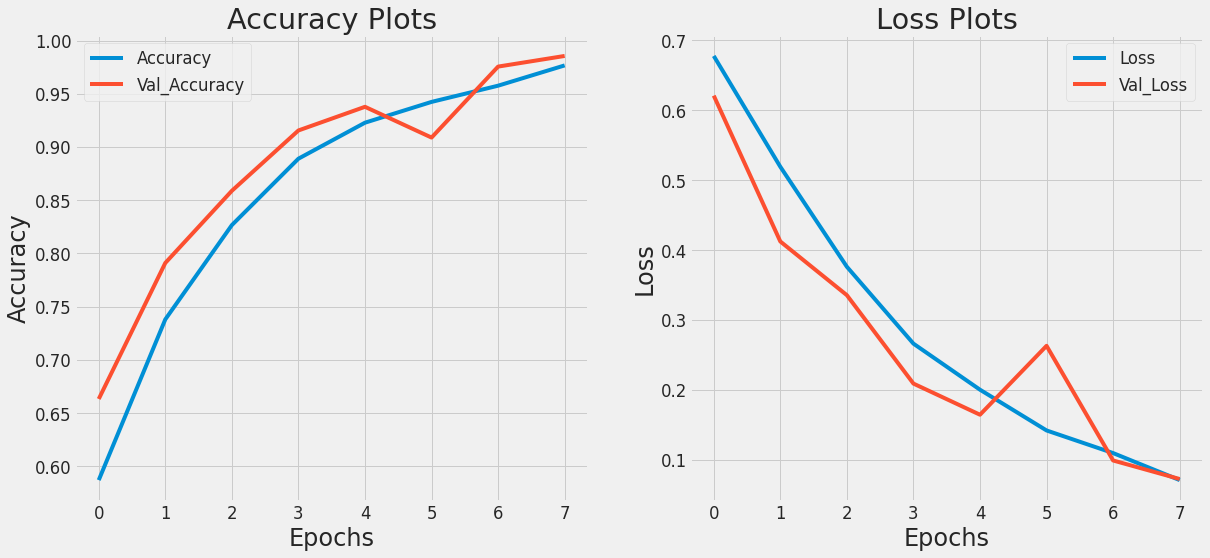

In [158]:
with plt.style.context(style='fivethirtyeight'):
    plt.figure(figsize=(18,8))
    plt.rcParams['font.size']=20
    plt.subplot(121)
    plt.plot(history.history['accuracy'],label='Accuracy')
    plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
    plt.title("Accuracy Plots")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val_Loss')
    plt.title("Loss Plots")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [159]:
#Training history is stored into a pickle file
with open(file='/content/drive/MyDrive/GenuineReviewerIdentification/training_history.pkl',mode='wb') as file:
    pickle.dump(obj=history.history,file=file)

***Model Prediction***

In [160]:
#predict() will perform predictions on the testing instances
model_pred=model.predict(x=X_test,batch_size=32,verbose=1)
print(model_pred)

29/29 [==============================] - 2s 14ms/step
[[1.9468460e-03 9.9804807e-01]
 [3.3221105e-03 9.9674040e-01]
 [1.2409559e-02 9.8797041e-01]
 ...
 [9.9961901e-01 3.7241465e-04]
 [4.3172208e-03 9.9575716e-01]
 [2.4279254e-03 9.9755043e-01]]


In [161]:
#Coverting probabilities back to labels
pred_label=[]
for i in range(len(model_pred)):
    pred_label.append(np.argmax(model_pred[i]))
true_label=[]
for i in range(len(y_test)):
    true_label.append(np.argmax(y_test[i]))
print(true_label[:50])

[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]


### Result Analysis

***Accuracy score***

In [162]:
model_accuracy=accuracy_score(y_true=true_label,y_pred=pred_label)
print("Overall validated accuracy of the model is {:.2f}%".format(model_accuracy*100.0))

Overall validated accuracy of the model is 98.56%


***Classification Report***

In [163]:
print(classification_report(y_true=true_label,y_pred=pred_label,target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       1.00      0.97      0.99       446
    negative       0.97      1.00      0.99       454

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



In [164]:
y_pred=pred_label

In [165]:
#CALCULATE MEAN SQUARED ERROR BETWEEN THE TESTING SETS
'''The mean squared error is a common way to measure the prediction accuracy of a model. The mean squared error measures
the average of the squares of the errors. What this means, is that it returns the average of the sums of the square of each 
difference between the estimated value and the true value. The mean squared error is a common way to measure the prediction 
accuracy of a model.'''

#X_train,X_test,y_train,y_test=train_test_split(pad_text,y,test_size=0.3,random_state=37)


from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, model.predict(X_test))
mse

29/29 [==============================] - 0s 10ms/step


0.015831621

In [166]:
#CHECK RMSE - ROOT MEAN SQUARED ERROR
import math
rmse = math.sqrt(mse)
rmse

0.125823771059999

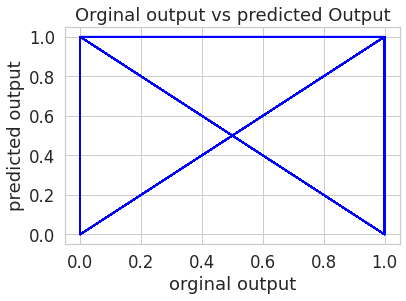

In [167]:
#ORIGINAL OUTPUT VS PREDICTED OUTPUT PLOT
import seaborn as sns
from matplotlib import pyplot as plt
plt.plot(y_test, y_pred, color='blue')
plt.title('Orginal output vs predicted Output')
plt.xlabel('orginal output')
plt.ylabel('predicted output')
plt.show()

***Confusion Matrix***



[[433  13]
 [  0 454]]




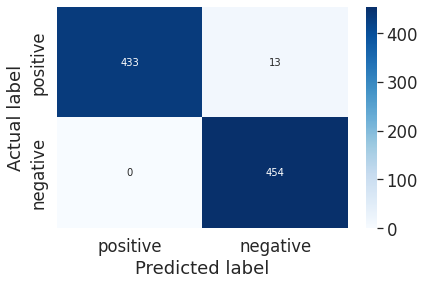

In [168]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true=true_label,y_pred=pred_label)
print("\n")
print(matrix)
print("\n");
import seaborn as sns
class_names = ["positive","negative"]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
cm=confusion_matrix(y_true=true_label,y_pred=pred_label)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names, )
sns.heatmap(df_cm,annot=True,cmap="Blues",fmt="d")
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
ax.xaxis.set_label_position('bottom')
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label');
#plt.show()

***Model Saving***

In [169]:
model.save(filepath="/content/drive/MyDrive/GenuineReviewerIdentification/ConvolutionalLongShortTermMemory.h5")

# **GENUINE REVIEWER IDENTIFICATION**

Data Loading

In [170]:
data=pd.read_csv('/content/drive/MyDrive/GenuineReviewerIdentification/mockaroo_dataset.csv')
data=data.dropna()
data.head()

,Name,product_name,Review
0,Amazon Customer,Geneva Platinum Analogue Gold Dial Women's Wat...,the speaker voice quality is terrible compare ...
1,Mitchel,NUBELA Analogue Prizam Glass Black Dial Girl's...,Does as advertise. Good for bedroom and you ca...
2,Alex,Timewear Analogue Round Beige Dial Women's Wat...,Use is all the time. Backyard favorite. Great ...
3,Debolina,Sonata Analog White Dial Women's Watch -NJ8989...,Brought this as a gift for my sister and she a...
4,Edward,Timewear Analogue Round Beige Dial Women's Wat...,I am extremely pleased with this case. Though ...


In [171]:
data.shape

(1894, 3)

Model Loading

In [172]:
with open(file='/content/drive/MyDrive/GenuineReviewerIdentification/Tokenizer.pkl',mode='rb') as file:
    tokenizer=pickle.load(file=file)

In [173]:
#.h5 extension because tensorflow library is used
#convolutional long short term memory which is trained is loaded
model=load_model(filepath='/content/drive/MyDrive/GenuineReviewerIdentification/ConvolutionalLongShortTermMemory.h5')

Text Cleaning

In [174]:
import string
punctuations=string.punctuation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords=set(STOP_WORDS)
nlp=spacy.load("en_core_web_sm")

In [175]:
def text_cleaning(docx):
    sentence=[word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in docx]
    sentence=[word for word in sentence if word not in stopwords and word not in punctuations]
    sentence=[word for word in sentence if len(word)>1 and word.isalpha()]
    sentence=" ".join(sentence)
    return sentence

In [176]:
import re
import pickle

with open("/content/drive/MyDrive/GenuineReviewerIdentification/cword_dict.pkl",mode='rb') as file:
    cList=pickle.load(file=file)
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group()]
    return c_re.sub(replace, text)

In [ ]:
from tqdm.notebook import tqdm
cleaned_sentence=[]
for sentence in tqdm(data['Review'].values):
    sent=expandContractions(sentence)
    sent=nlp(sent.lower())
    cleaned_sentence.append(text_cleaning(sent))
data['Review']=cleaned_sentence
data['Review']=data['Review'].apply(str)

  0%|          | 0/1894 [00:00<?, ?it/s]

In [ ]:
data.head()

,Name,product_name,Review
0,Amazon Customer,Geneva Platinum Analogue Gold Dial Women's Wat...,speaker voice quality terrible compare similar...
1,Mitchel,NUBELA Analogue Prizam Glass Black Dial Girl's...,advertise good bedroom plug external speaker
2,Alex,Timewear Analogue Round Beige Dial Women's Wat...,use time backyard favorite great fire
3,Debolina,Sonata Analog White Dial Women's Watch -NJ8989...,bring gift sister absolutely love great produc...
4,Edward,Timewear Analogue Round Beige Dial Women's Wat...,extremely pleased case lightweight construct c...


In [ ]:
data.shape

(1894, 3)

In [ ]:
#Tokenization and sequence padding - Reviews converted into sequence data format
#pad_sequences to pad the text with same dimensionality 
sequence_data=tokenizer.texts_to_sequences(data['Review'].values)
pad_text=pad_sequences(sequences=sequence_data,maxlen=200,padding='post',truncating='post')

In [ ]:
#predict() will perform predictions on the testing instances
prediction=model.predict(pad_text,batch_size=32,verbose=1)
print(prediction)

60/60 [==============================] - 2s 12ms/step
[[2.2867151e-02 9.7714978e-01]
 [9.9239516e-01 7.3900404e-03]
 [9.9948549e-01 4.9306045e-04]
 ...
 [9.9999428e-01 5.9714271e-06]
 [9.9456137e-01 5.2709756e-03]
 [2.8097869e-03 9.9723059e-01]]


In [ ]:
pred_label=[]
for i in range(len(prediction)):
    pred_label.append(np.argmax(prediction[i]))

# **PRODUCT CROWD SENTIMENT**

In [ ]:
print(pred_label)

[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 

In [ ]:
#Sentiment column clubbed to the existing dataframe
data['sentiment']=pred_label ####cnn-lstm sentiment analysis utilised here
data=data.sample(frac=1).reset_index(drop=True)
data.head()

,Name,product_name,Review,sentiment
0,M RAMESH,Everyday Analog Black Dial Women's Watch -NK80...,update year review ad gb wifi hdx use galaxy a...,0
1,AP,Timewear Analogue Round Beige Dial Women's Wat...,shop long time find pleased,0
2,ARUP DAS,Adamo Analog Blue Dial Women's Watch-9710SM40,connection drop unit pretty bad hardly game di...,1
3,Ramya,Geneva Platinum Analogue Gold Dial Women's Wat...,great cover turn device opening closing work g...,0
4,Amazon Customer,hope the metal is not good of watch so what v...,love aspect echo buy tap,0


In [ ]:
#Unique Products List
unique_products=list(data['product_name'].unique())
print(unique_products)

["Everyday Analog Black Dial Women's Watch -NK8085SM01", "Timewear Analogue Round Beige Dial Women's Watch - 107Wdtl", "Adamo Analog Blue Dial Women's Watch-9710SM40", "Geneva Platinum Analogue Gold Dial Women's Watch -GNV01", ' hope the metal is not good of watch so what very bad smell', "Sonata SFAL Analog Silver Dial Women's Watch -NK8080SM01", "Sonata Analog White Dial Women's Watch -NJ8989PP03C", "Sonata Analog Champagne Dial Women's Watch-NK87018YM01", "IIk Collection Watches Stainless Steel Chain Day and Date Analogue Silver Dial Women's Watch", "Adamo Analog Blue Dial Women's Watch-9710SM13", 'Geneva Platinum Silicone Strap Analogue Watch for Women & Girls - GP-379', '0', 'Analogue Pink', 'Helpful', "NUBELA Analogue Prizam Glass Black Dial Girl's Watch", '4', "Adamo Analog Blue Dial Women's Watch-9710SM35", '2', "Adamo Analog Blue Dial Women's Watch-9710SM124", "Adamo Analog Blue Dial Women's Watch-9710SM127", "Adamo Analog Blue Dial Women's Watch-9710SM19", '1', ' the quality 

Then a product dictionary is created where key is the unique product name and value is the empty list. 

In [ ]:
#Product dictionary with product name as the key. Value is a null list
product_dictionary={}
for product in unique_products:
    product_dictionary[product]=[]
print(product_dictionary)

{"Everyday Analog Black Dial Women's Watch -NK8085SM01": [], "Timewear Analogue Round Beige Dial Women's Watch - 107Wdtl": [], "Adamo Analog Blue Dial Women's Watch-9710SM40": [], "Geneva Platinum Analogue Gold Dial Women's Watch -GNV01": [], ' hope the metal is not good of watch so what very bad smell': [], "Sonata SFAL Analog Silver Dial Women's Watch -NK8080SM01": [], "Sonata Analog White Dial Women's Watch -NJ8989PP03C": [], "Sonata Analog Champagne Dial Women's Watch-NK87018YM01": [], "IIk Collection Watches Stainless Steel Chain Day and Date Analogue Silver Dial Women's Watch": [], "Adamo Analog Blue Dial Women's Watch-9710SM13": [], 'Geneva Platinum Silicone Strap Analogue Watch for Women & Girls - GP-379': [], '0': [], 'Analogue Pink': [], 'Helpful': [], "NUBELA Analogue Prizam Glass Black Dial Girl's Watch": [], '4': [], "Adamo Analog Blue Dial Women's Watch-9710SM35": [], '2': [], "Adamo Analog Blue Dial Women's Watch-9710SM124": [], "Adamo Analog Blue Dial Women's Watch-9710

In the next step for each dictionary item, we are calculating how many times it scored positive sentiment and how many times it scored negative sentiment. Based on the unique product name and dictionary product name & sentiment, the score is calculated at each places.

In [ ]:
#Value is appended with the sentiment
for index,features in data.iterrows():
    for key,values in product_dictionary.items():
        if features['product_name']==key:
            if features['sentiment']==0:
                product_dictionary[key].append(0)
            else:
                product_dictionary[key].append(1)
        else:
            continue

In [ ]:
print(product_dictionary)

{"Everyday Analog Black Dial Women's Watch -NK8085SM01": [0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0], "Timewear Analogue Round Beige Dial Women's Watch - 107W

Then 0's and 1's count is taken and overall status is marked as positive or negative. Overall status indicates the product crowd sentiment.

In [ ]:
#overall sentiment
overall_sentiment=[]
for key,value in product_dictionary.items():
    positive=value.count(0)
    negative=value.count(1)
    if positive>negative:
        overall_sentiment.append('positive')
    else:
        overall_sentiment.append("negative")

In [ ]:
#Product Crowd Sentiment
unique_overall_df=pd.DataFrame(data={'product_name':unique_products,'overall_status':overall_sentiment})
unique_overall_df.head()

,product_name,overall_status
0,Everyday Analog Black Dial Women's Watch -NK80...,negative
1,Timewear Analogue Round Beige Dial Women's Wat...,negative
2,Adamo Analog Blue Dial Women's Watch-9710SM40,negative
3,Geneva Platinum Analogue Gold Dial Women's Wat...,negative
4,hope the metal is not good of watch so what v...,positive


In [ ]:
data.head()

,Name,product_name,Review,sentiment
0,M RAMESH,Everyday Analog Black Dial Women's Watch -NK80...,update year review ad gb wifi hdx use galaxy a...,0
1,AP,Timewear Analogue Round Beige Dial Women's Wat...,shop long time find pleased,0
2,ARUP DAS,Adamo Analog Blue Dial Women's Watch-9710SM40,connection drop unit pretty bad hardly game di...,1
3,Ramya,Geneva Platinum Analogue Gold Dial Women's Wat...,great cover turn device opening closing work g...,0
4,Amazon Customer,hope the metal is not good of watch so what v...,love aspect echo buy tap,0


In [ ]:
#Unique Users
unique_users=data['Name'].unique()
print(list(unique_users))

['M RAMESH', 'AP', 'ARUP DAS', 'Ramya', 'Amazon Customer', 'Srinivas', 'Akshatha', 'TOM', 'Vaishnavi Ahir', 'Venu', 'Nikhil Pancholi', "Dip's", 'mayur sarna', 'Souvick Bhattacharjee', 'Saju', "Let's make it", 'Archismita', 'Nidhi', 'La I.', 'Alex', 'KURELLA HARISH KUMAR', 'Amit Gulati', 'Sumit', 'Arun Kumar', 'nathaniel', 'vignesh', 'Sonam', 'Lakshmikanthan', 'Chaithanya kumar S', 'Raye', 'Vibhavari', 'Charles vijay', 'Priyanka', 'Sohan', 'Ruby', 'Pranav kumar', 'Lovelin Tripathy', 'Akeshraj', 'Prashanthi', 'Nm reddy', 'Vasireddy', 'Alina', 'ranjith', 'Victoria @ viji', 'Satishkumar P', 'arti thakur', 'Nandni patel', 'Neo_Ron', 'I P', 'Kuldeep meena', 'Annette', 'manish yadav', 'Salangjmt', 'Shivam Sharma', 'ishani', 'V M EZHILARASAN', 'HirenKumar Makwana', 'Vel', 'Dinakar MS', 'Manish kumar tomar', 'SRI', 'Abhi', 'user', 'Arun kumar', 'Chitirala N.', 'Debo', 'Balakumaran', 'Riswana Rinu', 'Jyotsna', 'Sam', 'Balachandar', 'Disha', 'Banti Brahma', 'Himanshu Hota', 'VINOD.T', 'Riddhi r.'

In [ ]:
#User dictionary with username as key and value as a null list
users_dictionary={}
for user in unique_users:
    users_dictionary[user]=[]
print(users_dictionary)

{'M RAMESH': [], 'AP': [], 'ARUP DAS': [], 'Ramya': [], 'Amazon Customer': [], 'Srinivas': [], 'Akshatha': [], 'TOM': [], 'Vaishnavi Ahir': [], 'Venu': [], 'Nikhil Pancholi': [], "Dip's": [], 'mayur sarna': [], 'Souvick Bhattacharjee': [], 'Saju': [], "Let's make it": [], 'Archismita': [], 'Nidhi': [], 'La I.': [], 'Alex': [], 'KURELLA HARISH KUMAR': [], 'Amit Gulati': [], 'Sumit': [], 'Arun Kumar': [], 'nathaniel': [], 'vignesh': [], 'Sonam': [], 'Lakshmikanthan': [], 'Chaithanya kumar S': [], 'Raye': [], 'Vibhavari': [], 'Charles vijay': [], 'Priyanka': [], 'Sohan': [], 'Ruby': [], 'Pranav kumar': [], 'Lovelin Tripathy': [], 'Akeshraj': [], 'Prashanthi': [], 'Nm reddy': [], 'Vasireddy': [], 'Alina': [], 'ranjith': [], 'Victoria @ viji': [], 'Satishkumar P': [], 'arti thakur': [], 'Nandni patel': [], 'Neo_Ron': [], 'I P': [], 'Kuldeep meena': [], 'Annette': [], 'manish yadav': [], 'Salangjmt': [], 'Shivam Sharma': [], 'ishani': [], 'V M EZHILARASAN': [], 'HirenKumar Makwana': [], 'Vel

Then the user reviews are checked and if it's sentiment is same as the product crowd sentiment, then the value in the user dictionary will be marked as "WithCrowd", otherwise "AgainstCrowd"

In [ ]:
#User crowd sourcing behaviour
for indices1,features1 in data.iterrows(): #user
    for indices2,features2 in unique_overall_df.iterrows(): #product_crowd
        if features1['product_name']==features2['product_name']:
            sent=''
            if features1['sentiment']==0:
                sent='positive'
            else:
                sent='negative'
            if sent==features2['overall_status']:
                for key,value in users_dictionary.items():
                    if features1['Name']==key:
                        users_dictionary[key].append("WithCrowd")
            else:
                for key,value in users_dictionary.items():
                    if features1['Name']==key:
                        users_dictionary[key].append("AgainstCrowd")

In [ ]:
print(users_dictionary)

{'M RAMESH': ['AgainstCrowd'], 'AP': ['AgainstCrowd'], 'ARUP DAS': ['WithCrowd'], 'Ramya': ['AgainstCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd'], 'Amazon Customer': ['WithCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'AgainstCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'AgainstCrowd', 'AgainstCrowd', 'AgainstCrowd', 'AgainstCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'AgainstCrowd', 'AgainstCrowd', 'AgainstCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'WithCrowd', 'WithCrowd', 'WithCrowd', 'WithCrowd', 'AgainstCrowd', 'AgainstCrowd', 'AgainstCrowd

In [ ]:
#Counting how many times each user stood with crowd and against crowd.
with_crowd=[]
against_crowd=[]
for key,value in users_dictionary.items():
    with_crowd.append(value.count('WithCrowd'))
    against_crowd.append(value.count('AgainstCrowd'))

# **Genuine Score Calculation**

In [ ]:
#Users are given +2 marks for genuine reviews and -2 marks for fake reviews
#Difference of both scores will give the Genuine Score for each user
result=pd.DataFrame(data={'Users':users_dictionary.keys(),'GenuineReviewCounts': with_crowd,'NotGenuineReviewCounts': against_crowd})
result=result.fillna(0)
result['GenuineScore']= (result['GenuineReviewCounts']*2) - (result['NotGenuineReviewCounts']*2) 
result=result.sort_values(by='GenuineScore',ascending=False).reset_index(drop=True)
result.head()

,Users,GenuineReviewCounts,NotGenuineReviewCounts,GenuineScore
0,Amazon Customer,175,137,76
1,Swathi,3,0,6
2,Manisha,3,0,6
3,Lakshmi Potsangbam,2,0,4
4,Manpreet,2,0,4


In [ ]:
result.tail()

,Users,GenuineReviewCounts,NotGenuineReviewCounts,GenuineScore
1398,Ronnie,0,2,-4
1399,Harini,0,2,-4
1400,Anis Sayyed,0,2,-4
1401,Ritu,0,3,-6
1402,Angel,0,3,-6


In [ ]:
result=result[["GenuineScore"]]
print((result < 0).sum().sum())


566


In [ ]:
result=result[["GenuineScore"]]
print((result.GenuineScore.values < 0).sum())


566


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/GenuineReviewerIdentification/7817_1.csv')
data.head(2)

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,manufacturer,manufacturerNumber,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-08-08T00:00:00.000Z,NaN,139.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-09-01T00:00:00.000Z,NaN,126.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams


In [ ]:
data=data[["reviews.username", "name", "reviews.text"]]
data.shape

(1597, 3)

In [ ]:
with open(file='/content/drive/MyDrive/GenuineReviewerIdentification/Tokenizer.pkl',mode='rb') as file:
    tokenizer=pickle.load(file=file)

In [ ]:
model=load_model(filepath='/content/drive/MyDrive/GenuineReviewerIdentification/ConvolutionalLongShortTermMemory.h5')

In [ ]:
import string
punctuations=string.punctuation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords=set(STOP_WORDS)
nlp=spacy.load("en_core_web_sm")

In [ ]:
def text_cleaning(docx):
    sentence=[word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in docx]
    sentence=[word for word in sentence if word not in stopwords and word not in punctuations]
    sentence=[word for word in sentence if len(word)>1 and word.isalpha()]
    sentence=" ".join(sentence)
    return sentence

In [ ]:
import re
import pickle

with open("/content/drive/MyDrive/GenuineReviewerIdentification/cword_dict.pkl",mode='rb') as file:
    cList=pickle.load(file=file)
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group()]
    return c_re.sub(replace, text)

In [ ]:
from tqdm.notebook import tqdm
cleaned_sentence=[]
for sentence in tqdm(data['reviews.text'].values):
    sent=expandContractions(sentence)
    sent=nlp(sent.lower())
    cleaned_sentence.append(text_cleaning(sent))
data['reviews.text']=cleaned_sentence
data['reviews.text']=data['reviews.text'].apply(str)

  0%|          | 0/1597 [00:00<?, ?it/s]

In [ ]:
sequence_data=tokenizer.texts_to_sequences(data['reviews.text'].values)
pad_text=pad_sequences(sequences=sequence_data,maxlen=200,padding='post',truncating='post')

In [ ]:
#predict() will perform predictions on the testing instances
prediction=model.predict(pad_text,batch_size=32,verbose=1)
print(prediction)

50/50 [==============================] - 2s 13ms/step
[[9.9999595e-01 4.4090571e-06]
 [9.9999785e-01 2.4697003e-06]
 [9.9996066e-01 3.7944032e-05]
 ...
 [1.5572973e-03 9.9850851e-01]
 [9.9418420e-01 5.8429376e-03]
 [9.5811387e-04 9.9906212e-01]]


In [ ]:
pred_label=[]
for i in range(len(prediction)):
    pred_label.append(np.argmax(prediction[i]))

In [ ]:
print(pred_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
#Sentiment column clubbed to the existing dataframe
data['sentiment']=pred_label
data=data.sample(frac=1).reset_index(drop=True)
data.head()

,reviews.username,name,reviews.text,sentiment
0,Sevirj89,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,alexa great addition portable rechargeable goo...,0
1,Jeffrey Stanley,Kindle Keyboard,kindle ink reader ipad iphone window base phon...,0
2,jacoba,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,gift plan purchase pleased portability sound q...,0
3,Erik,Amazon Fire TV,like fire tv box far voice search thing pretty...,0
4,Dallas,Amazon Fire TV,official comment amazon team saysjuly dallas t...,0


In [ ]:
#Unique Products List
unique_products=list(data['name'].unique())
print(unique_products)

In [ ]:
#Product dictionary with product name as the key. Value is a null list
product_dictionary={}
for product in unique_products:
    product_dictionary[product]=[]
print(product_dictionary)

{'Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker': [], 'Kindle Keyboard': [], 'Amazon Fire TV': [], 'Kindle Oasis with Leather Charging Cover - Black': [], 'All-New Amazon Fire HD 8 Tablet Case (7th Generation': [], 'Kindle for Kids Bundle with the latest Kindle E-reader': [], 'All-New Amazon Fire 7 Tablet Case (7th Generation': [], 'Fire HD 6 Tablet': [], 'Amazon Premium Headphones': [], 'Kindle Fire HD 7"': [], 'Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders': [], 'Amazon Echo Dot Case (fits Echo Dot 2nd Generation only) - Indigo Fabric': [], 'Echo Dot (2nd Generation) - Black': [], 'Amazon Tap Sling Cover - White': [], 'Amazon Echo Dot Case (fits Echo Dot 2nd Generation only) - Saddle Tan Leather': [], 'Kindle Fire HDX 7"': [], 'All-New Fire 7 Tablet with Alexa': [], 'Kindle Paperwhite': [], 'All-New Amazon Kid-Proof Case for Amazon Fire 7 Tablet (7th Generation': [], 'Amazon Kindle Oasis Premium Leather Battery Cover - Black': [], '

In [ ]:
#Value is appended with the sentiment
for index,features in data.iterrows():
    for key,values in product_dictionary.items():
        if features['name']==key:
            if features['sentiment']==0:
                product_dictionary[key].append(0)
            else:
                product_dictionary[key].append(1)
        else:
            continue

In [ ]:
#Value is appended with the sentiment
for index,features in data.iterrows():
    for key,values in product_dictionary.items():
        if features['name']==key:
            if features['sentiment']==0:
               product_dictionary[key].append(0)
            else:
               product_dictionary[key].append(1)
        else:
            continue

In [ ]:
print(product_dictionary)

In [ ]:
#overall sentiment
overall_sentiment=[]
for key,value in product_dictionary.items():
    positive=value.count(0)
    negative=value.count(1)
    if positive>negative:
        overall_sentiment.append('positive')
    else:
        overall_sentiment.append("negative")

In [ ]:
#Product Crowd Sentiment
unique_overall_df=pd.DataFrame(data={'name':unique_products,'overall_status':overall_sentiment})
unique_overall_df.head()

In [ ]:
#Unique Users
unique_users=data['reviews.username'].unique()
print(list(unique_users))

In [ ]:
#User dictionary with username as key and value as a null list
users_dictionary={}
for user in unique_users:
    users_dictionary[user]=[]
print(users_dictionary)

In [ ]:
#User crowd sourcing behaviour
for indices1,features1 in data.iterrows(): #user
    for indices2,features2 in unique_overall_df.iterrows(): #product_crowd
        if features1['name']==features2['name']:
            sent=''
            if features1['sentiment']==0:
                sent='positive'
            else:
                sent='negative'
            if sent==features2['overall_status']:
                for key,value in users_dictionary.items():
                    if features1['reviews.username']==key:
                        users_dictionary[key].append("WithCrowd")
            else:
                for key,value in users_dictionary.items():
                    if features1['reviews.username']==key:
                        users_dictionary[key].append("AgainstCrowd")

In [ ]:
#Counting how many times each user stood with crowd and against crowd.
with_crowd=[]
against_crowd=[]
for key,value in users_dictionary.items():
    with_crowd.append(value.count('WithCrowd'))
    against_crowd.append(value.count('AgainstCrowd'))

In [ ]:
#Users are given +2 marks for genuine reviews and -2 marks for fake reviews
#Difference of both scores will give the Genuine Score for each user
result=pd.DataFrame(data={'Users':users_dictionary.keys(),'GenuineReviewCounts': with_crowd,'NotGenuineReviewCounts': against_crowd})
result=result.fillna(0)
result['GenuineScore']= (result['GenuineReviewCounts']*2) - (result['NotGenuineReviewCounts']*2) 
result=result.sort_values(by='GenuineScore',ascending=False).reset_index(drop=True)
result.head()

In [ ]:
result.tail()

In [ ]:
result=result[["GenuineScore"]]
print((result.GenuineScore.values < 0).sum())